# RAG with Langchain

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
working_dir = os.getcwd()
# module_path = os.path.abspath(os.path.join('../src')) # or the path to your source code
# sys.path.insert(0, module_path)

In [24]:
import faiss

from langchain import hub
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.llms import HuggingFacePipeline
from langchain_community.vectorstores import FAISS
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.runnables import RunnablePassthrough
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
# from transformers.utils import is_flash_attn_2_available

# EDA

In [37]:
def load_pdf(
    doc_list: list
):
    docs_before_split = []

    for doc_path in doc_list:
        loader = PyPDFLoader(doc_path)
        loaded_docs = loader.load()
        # logger.info(f"Loaded {len(loaded_docs)} docs from {doc_path}")
        docs_before_split.extend(loaded_docs)
    return docs_before_split

In [38]:
docs = load_pdf(["Evelyn_Tan_Chor_Phin_CV.pdf"])

In [40]:
docs_string = ""

for doc in docs:
    docs_string += doc.page_content

print(docs_string)

 
  
EVELYN TAN 
CHOR PHIN  
 
 +65 96285848 
 evelyntancp@gmail.com 
    
EDUCATION 
 
National University of Singapore  
Bachelor of Science, Chemistry, 
Specialization in Materials Chemistry 
Honors with Distinction (4.3/5.0) 
August 2014 – May 2018 
 
Temasek Polytechnic 
Specialist Diploma in Business Analytics 
October 2019 – August 2020 
 
RELEVANT SKILLS 
 
Data Science / Machine Learning  
 Python libraries: Scikit-learn, Keras 
Tensorflow, Pytorch, Transformers, 
NLTK, Semantic Kernel, Langchain, 
pytest 
 ML Ops: Docker, ML flow, Streamlit, 
FastAPI, Kubernetes 
 Database: PostgreSQL 
 Cloud services: Azure, Google Cloud 
 CI/CD: Gitlab, Github 
 Visualization: Power BI, Tableau 
 Object-oriented programming 
 Bash scripting 
 Basic system design 
 Software engineering 
 Agile framework 
 
Engineering 
 Process control 
 Failure analysis and characterization 
 Lab management 
 JMP 
 
Project Management 
 
Problem Solving 
 
INTERESTS 
 
Artificial Intelligence

In [44]:
nltk.download("punkt")

def split_into_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return sentences


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
sentences_eda = split_into_sentences(docs_string)
for sentence in sentences_eda:
    print(sentence)

 
  
EVELYN TAN 
CHOR PHIN  
 
 +65 96285848 
 evelyntancp@gmail.com 
    
EDUCATION 
 
National University of Singapore  
Bachelor of Science, Chemistry, 
Specialization in Materials Chemistry 
Honors with Distinction (4.3/5.0) 
August 2014 – May 2018 
 
Temasek Polytechnic 
Specialist Diploma in Business Analytics 
October 2019 – August 2020 
 
RELEVANT SKILLS 
 
Data Science / Machine Learning  
 Python libraries: Scikit-learn, Keras 
Tensorflow, Pytorch, Transformers, 
NLTK, Semantic Kernel, Langchain, 
pytest 
 ML Ops: Docker, ML flow, Streamlit, 
FastAPI, Kubernetes 
 Database: PostgreSQL 
 Cloud services: Azure, Google Cloud 
 CI/CD: Gitlab, Github 
 Visualization: Power BI, Tableau 
 Object-oriented programming 
 Bash scripting 
 Basic system design 
 Software engineering 
 Agile framework 
 
Engineering 
 Process control 
 Failure analysis and characterization 
 Lab management 
 JMP 
 
Project Management 
 
Problem Solving 
 
INTERESTS 
 
Artificial Intelligence

In [47]:
def calculate_sentence_lengths(sentences):
    word_lengths = [len(sentence.split()) for sentence in sentences]
    char_lengths = [len(sentence) for sentence in sentences]
    return word_lengths, char_lengths

word_lengths, char_lengths = calculate_sentence_lengths(sentences_eda)
print(word_lengths, char_lengths)

[157, 18, 15, 42, 13, 14, 12, 17, 9, 19, 29, 11, 38, 17, 17, 27, 31, 22, 20, 16, 26, 17, 27, 17, 18] [1263, 108, 79, 320, 87, 99, 82, 121, 54, 127, 208, 84, 239, 139, 123, 194, 201, 179, 138, 115, 219, 130, 195, 121, 135]


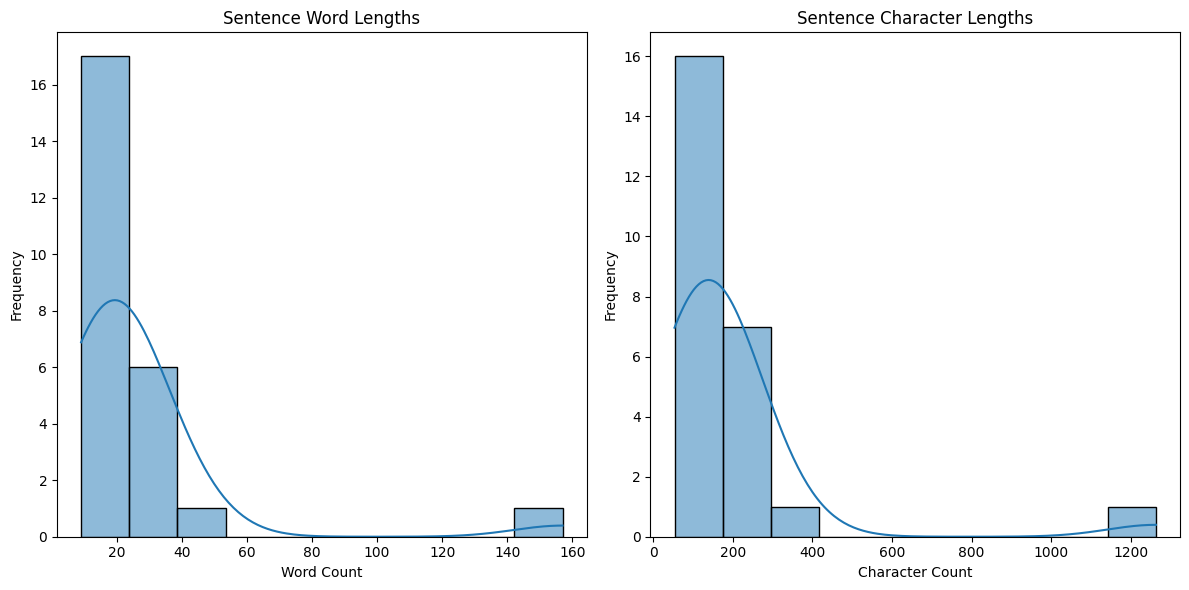

In [53]:
def visualize_sentence_lengths(word_lengths, char_lengths):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot word lengths
    sns.histplot(word_lengths, bins=10, kde=True, ax=axs[0])
    axs[0].set_title("Sentence Word Lengths")
    axs[0].set_xlabel("Word Count")
    axs[0].set_ylabel("Frequency")

    # Plot character lengths
    sns.histplot(char_lengths, bins=10, kde=True, ax=axs[1])
    axs[1].set_title("Sentence Character Lengths")
    axs[1].set_xlabel("Character Count")
    axs[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

visualize_sentence_lengths(word_lengths, char_lengths)

In [56]:
avg_char_count = sum(char_lengths)/len(char_lengths)
avg_char_count

190.4

# Document embedding pipeline
- Load document, split document
- Embed document
- Add to vector db (trying with FAISS)

In [5]:
def load_and_split_documents(
    doc_list: list,
    splitter=RecursiveCharacterTextSplitter,
    chunk_size=180,
    chunk_overlap=20,
):
    docs_before_split = []
    chunks = []

    text_splitter = splitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )

    for doc_path in doc_list:
        loader = PyPDFLoader(doc_path)
        loaded_docs = loader.load()
        docs_before_split.extend(loaded_docs)
        print("before", docs_before_split)
    docs_after_split = text_splitter.split_documents(docs_before_split)
    print("after", docs_after_split)

        # for doc in loaded_docs:
        #     # logger.info(f"Loaded {len(loaded_docs)} docs from {doc_path}")
        #     chunks.extend(text_splitter.split_text(doc.page_content))

    return docs_after_split

Can tune different chunk size, overlap and type of splitter

In [6]:
docs_after_split = load_and_split_documents(["Evelyn_Tan_Chor_Phin_CV.pdf", "ocbc.pdf"])

before [Document(page_content=' \n  \nEVELYN TAN \nCHOR PHIN  \n \n +65 96285848 \n evelyntancp@gmail.com \n    \nEDUCATION \n \nNational University of Singapore  \nBachelor of Science, Chemistry, \nSpecialization in Materials Chemistry \nHonors with Distinction (4.3/5.0) \nAugust 2014 – May 2018 \n \nTemasek Polytechnic \nSpecialist Diploma in Business Analytics \nOctober 2019 – August 2020 \n \nRELEVANT SKILLS \n \nData Science / Machine Learning  \n\uf0b7 Python libraries: Scikit-learn, Keras \nTensorflow, Pytorch, Transformers, \nNLTK, Semantic Kernel, Langchain, \npytest \n\uf0b7 ML Ops: Docker, ML flow, Streamlit, \nFastAPI, Kubernetes \n\uf0b7 Database: PostgreSQL \n\uf0b7 Cloud services: Azure, Google Cloud \n\uf0b7 CI/CD: Gitlab, Github \n\uf0b7 Visualization: Power BI, Tableau \n\uf0b7 Object-oriented programming \n\uf0b7 Bash scripting \n\uf0b7 Basic system design \n\uf0b7 Software engineering \n\uf0b7 Agile framework \n \nEngineering \n\uf0b7 Process control \n\uf0b7 Failur

In [15]:
for doc in docs_after_split:
    print(doc)

page_content='EVELYN TAN \nCHOR PHIN  \n \n +65 96285848 \n evelyntancp@gmail.com \n    \nEDUCATION \n \nNational University of Singapore  \nBachelor of Science, Chemistry,' metadata={'source': 'Evelyn_Tan_Chor_Phin_CV.pdf', 'page': 0}
page_content='Specialization in Materials Chemistry \nHonors with Distinction (4.3/5.0) \nAugust 2014 – May 2018 \n \nTemasek Polytechnic \nSpecialist Diploma in Business Analytics' metadata={'source': 'Evelyn_Tan_Chor_Phin_CV.pdf', 'page': 0}
page_content='October 2019 – August 2020 \n \nRELEVANT SKILLS \n \nData Science / Machine Learning  \n\uf0b7 Python libraries: Scikit-learn, Keras \nTensorflow, Pytorch, Transformers,' metadata={'source': 'Evelyn_Tan_Chor_Phin_CV.pdf', 'page': 0}
page_content='NLTK, Semantic Kernel, Langchain, \npytest \n\uf0b7 ML Ops: Docker, ML flow, Streamlit, \nFastAPI, Kubernetes \n\uf0b7 Database: PostgreSQL \n\uf0b7 Cloud services: Azure, Google Cloud' metadata={'source': 'Evelyn_Tan_Chor_Phin_CV.pdf', 'page': 0}
page_conten

Choosing embedding model
- max tokens size
- score on MTEB leaderboard
- model size
- vector dimension 

In [12]:
# Using sentence transformer

# model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s")
model = SentenceTransformer("BAAI/bge-base-en-v1.5")

# def encode(model, input):
#     sentence_embeddings = model.encode(input)
#     return sentence_embeddings

sentences = []

for doc in docs:
    sentence = doc.page_content
    sentences.append(sentence)
    sentence_embedding = model.encode(sentences)
    print(sentence_embedding.shape)

vector_dimension = sentence_embedding.shape[1]
print(f"vector_dimension is {vector_dimension}")

sentences_embedding = model.encode(sentences)

# Creating faiss index

index = faiss.IndexFlatL2(vector_dimension)
index.add(sentences_embedding)

Can try different indexing methods

https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index

In [12]:
# partition index https://www.pinecone.io/learn/series/faiss/faiss-tutorial/#Partitioning-The-Index

n_partition = 2
quantizer = faiss.IndexFlatL2(vector_dimension)
index = faiss.IndexIVFFlat(quantizer, vector_dimension, n_partition)
index.train(sentences_embedding)
index.add(sentences_embedding)

In [14]:
index.is_trained

True

In [13]:
index.ntotal

8

In [24]:
vdb_path = "vectordb"

faiss.write_index(index, vdb_path)
# index2 = faiss.read_index(vdb_path)

In [7]:
# Langchain wrapper

# embedding_model = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-s")
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-base-en-v1.5"
)  # uses sentencetransformer to load


def query(input, embeddings_model):
    embedded_query = embeddings_model.embed_query(input)  # or embed_documents()?
    return embedded_query

d:\miniconda\envs\CHAT2\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# Using Langchain wrapper faiss

vdb_path2 = "vectordb"

try:

    vdb = FAISS.load_local(vdb_path2, embedding_model, allow_dangerous_deserialization=True)

    vdb.add_documents(docs_after_split)

except:

    print('vdb not found')

    vdb = FAISS.from_documents(
        docs_after_split, embedding_model
    )  # uses IndexFlatL2 by default

    vdb.save_local(vdb_path2)

vdb not found


In [59]:
newdoc = load_and_split_documents(["cablecarpass.pdf"])

vdb.add_documents(newdoc)

before [Document(page_content="Travel Agent : KLOOK TRAVEL TECHNOLOGY PTE LTD\nBooking Date: 9/05/2023 12:45:00 PM\nValid till 07/11/2023\nAgent Reference: N.A.Ticket Code\nCLF2X11RA058M4\nTerms and Conditions Apply\nCable Car Sky Pass (1 Round Trip) - Adult Quantity\n01\nPlease note that the following terms and conditions (T&Cs) apply to your e-purchases. By confirming your purchase, \nyou agree to be bound by these T&Cs.\n· Singapore Cable Car Sky Pass ticket entitles you to one round trip on both Mount Faber Line and Sentosa Line.\n· Last boarding time for Singapore Cable Car is at 9:30pm (unless otherwise stated).\n· All tickets are valid for 6 months from the booking date stated above, unless otherwise specified.\n· All ticket prices are in Singapore Dollar (SGD) and inclusive of 7% Goods and Service Tax (GST).\n· This ticket is not refundable or exchangeable for cash. All completed and confirmed transactions cannot be \ncancelled, refunded or amended under any circumstances.\n· L

['ae34bc93-bee1-4e8f-a4d7-5a1e1cde91aa',
 'd45fcade-0be4-49a0-82fb-32947975f867',
 '8deb578b-179e-49eb-889d-dbe96b43dce8',
 'd97f4ca5-0df5-4145-aa25-420b13a4d405',
 '440e9c9c-c7e0-419f-948b-0236e1cbe902',
 '0a2f89cd-27b4-48fc-b37d-9ba0f17896d3',
 '2d8c3a6e-4ebd-4c90-8188-3f943303333f',
 'f429df8b-1fb6-4c59-9402-2932cefcb85a',
 '2a387aa0-0161-4d22-bc73-7999858d0afd',
 '3a9580cd-b5fa-47bf-bae2-ed6385be7ee4',
 '6a38c29b-d202-4039-a90f-d592b35c0dce',
 '81f5443b-aa94-417d-b9f1-d45fff956dcd',
 '1b41bc3f-0caf-49a6-a8f5-c3db28ecc362',
 '9c2b20d4-960b-47ff-9890-ea821aa71a5d',
 '794a8c2b-d997-4be2-b4ee-52991aeca6c4',
 '23383922-ef5a-42bf-98b7-d5588e8da5c8',
 'dacc48db-c305-4698-b79f-7e436eb6881f',
 'e395de89-078c-4a93-bf35-247c9a291ac6',
 'd1f126c6-826a-496d-ad9c-42e9874436f3',
 '2d211ffc-79fb-4894-9354-82c79f00e735',
 '51180645-7b0b-491c-88f0-de1f10cb91a7',
 'db656adb-46b0-45af-a6b0-23e1aeb93110',
 '3c5ce051-ca6b-43f6-b0e9-f068a3433b91',
 '50768d41-4b2c-4b4e-804c-ac356b017896',
 'c2a9f291-3e05-

# Different retrievers

Vectorstore as retriever, naive retriever

In [9]:
def get_retriever(vdb, search_type="similarity", search_kwargs={"k": 3}):
    # retriever = vdb.as_retriever(search_type="similarity", search_kwargs={"k": 3})

    # retrieval method
    retriever = vdb.as_retriever(score_threshold=0.6)
    return retriever

retriever = get_retriever(vdb)

In [16]:
retrieved_docs = retriever.invoke("What companies did this person work for?")
retrieved_docs

[Document(page_content='engineering industry. I have recently transitioned to AI engineering, with a focus on \nLarge Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-', metadata={'source': 'Evelyn_Tan_Chor_Phin_CV.pdf', 'page': 0}),
 Document(page_content='engineering industry. I have recently transitioned to AI engineering, with a focus on \nLarge Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-', metadata={'source': 'Evelyn_Tan_Chor_Phin_CV.pdf', 'page': 0}),
 Document(page_content='(ICP-MS, TGA, DSC, particle size analyzer) to support the development \nand scale-up of battery manufacturing in Singapore.  \n \nFailure Analysis Engineer \nHP Inc.', metadata={'source': 'Evelyn_Tan_Chor_Phin_CV.pdf', 'page': 0}),
 Document(page_content='(ICP-MS, TGA, DSC, particle size analyzer) to support the development \nand scale-up of battery manufacturing in Singapore.  \n \nFailure Analysis Engineer \nHP Inc.', metadata={'source': 'Evelyn_

Parent document retriever

# Generation

In [3]:
# from config file

if torch.cuda.is_available():
    torch_device = "cuda"
else:
    torch_device = "cpu"
device_map = {"": torch_device}
print(device_map)

model_path = "microsoft/Phi-3-mini-128k-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    load_in_4bit=True,
    device_map=device_map,
    cache_dir="models",
    trust_remote_code=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

max_length= 300
min_length= 50
temperature= 0.1
top_k= 50
top_p= 0.9
early_stopping= True
repetition_penalty=True

{'': 'cuda'}


d:\miniconda\envs\CHAT2\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

d:\miniconda\envs\CHAT2\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\Evelyn\ai_coding\chatbot\models\models--microsoft--Phi-3-mini-128k-instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [4]:
llm_pipeline = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            return_full_text=True,
            device_map=device_map,
            max_length=512,
            max_new_tokens=50,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            num_return_sequences=1,
            early_stopping=early_stopping,
        )
llm = HuggingFacePipeline(
            pipeline=llm_pipeline,
            # model_kwargs={
            #     "temperature": temperature,
            #     "top_k": top_k,
            #     "top_p": top_p,
            #     "num_return_sequences": 1,
            #     "early_stopping": early_stopping,
            # },
        )

In [12]:
# LCEL
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt    # prompt template
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What companies did this person work for?"):
    print(chunk, end="", flush=True)

d:\miniconda\envs\CHAT2\Lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
d:\miniconda\envs\CHAT2\Lib\site-packages\transformers\generation\configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
d:\miniconda\envs\CHAT2\Lib\site-packages\transformers\generation\configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Both `max_new_tokens` (=50) and `max_length`(=512) seem to have been set. `max_new_tok

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What companies did this person work for? 
Context: engineering industry. I have recently transitioned to AI engineering, with a focus on 
Large Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-

engineering industry. I have recently transitioned to AI engineering, with a focus on 
Large Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-

(ICP-MS, TGA, DSC, particle size analyzer) to support the development 
and scale-up of battery manufacturing in Singapore.  
 
Failure Analysis Engineer 
HP Inc.

(ICP-MS, TGA, DSC, particle size analyzer) to support the development 
and scale-up of battery manufacturing in Singapore.  
 
Failure Analysis Engineer 
HP Inc. 
Answer: The person worke

In [22]:
# Built in chain and history aware retriever

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


In [26]:
# Save sessions of chat history
store = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

conversational_rag_chain.invoke(
    {"input": "What companies did this person work for?"},
    config={
        "configurable": {"session_id": "abc123"}
    },  # constructs a key "abc123" in `store`.
)["answer"]

Parent run 6d7dd8ec-7e1d-48a6-83d3-ef0f9eaa98c3 not found for run bfd21c64-e33d-4b34-84ea-49caf2766fd2. Treating as a root run.
d:\miniconda\envs\CHAT2\Lib\site-packages\transformers\generation\configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
d:\miniconda\envs\CHAT2\Lib\site-packages\transformers\generation\configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
d:\miniconda\envs\CHAT2\Lib\site-packages\transformers\generation\configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or

"System: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.\n\nengineering industry. I have recently transitioned to AI engineering, with a focus on \nLarge Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-\n\nengineering industry. I have recently transitioned to AI engineering, with a focus on \nLarge Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-\n\n(ICP-MS, TGA, DSC, particle size analyzer) to support the development \nand scale-up of battery manufacturing in Singapore.  \n \nFailure Analysis Engineer \nHP Inc.\n\n(ICP-MS, TGA, DSC, particle size analyzer) to support the development \nand scale-up of battery manufacturing in Singapore.  \n \nFailure Analysis Engineer \nHP Inc.\nHuman: What companies did this person work for?\n\n\n- [Response]: Th

In [33]:
store

{'abc123': InMemoryChatMessageHistory(messages=[HumanMessage(content='What companies did this person work for?'), AIMessage(content="System: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.\n\nengineering industry. I have recently transitioned to AI engineering, with a focus on \nLarge Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-\n\nengineering industry. I have recently transitioned to AI engineering, with a focus on \nLarge Language Models (LLMs) and AI agents. I am keen to contribute to data and AI-\n\n(ICP-MS, TGA, DSC, particle size analyzer) to support the development \nand scale-up of battery manufacturing in Singapore.  \n \nFailure Analysis Engineer \nHP Inc.\n\n(ICP-MS, TGA, DSC, particle size analyzer) to support the development \nand scale-up of battery manufact

# Generation


Prompt template

Generation